# I. Introduction

## This notebook describes an approach to determining the optimal number of quadratic voting credits (C$_{qv}$) given how many distinct items (N) are being quadratically voted (V).

Optimal: In this case meaning equitable to all parties regardless of their voting strategy, with the tradeoffs fair and well known.

### $C_{qv} = f(N)$

### *Put simply, given a quadratic ballot of N issues, how many C$_{qv}$ should be given to each voter if the resulting votes must be whole integer numbers?*

----

### SUMMARY OF RESULTS:
Because the discreete method limits the ability to use anything but the squares of integers within the decision space of choices, especially at low N, unless there is an absolute requirement to use discrete voting, I recommend using continuous voting - where votes can be floats - but retaining using only integers for voting credits.  These are explored in another notebook {}.

----

### 1. Recap on QV:

$Vote_{n}= \sqrt{C_{qv,n}}$

where $n = [0,1,..,N]$

The total votes a voter casts on a given ballot are $\sum(Vote_{n})$, and the credits they spend to cast them $\sum(QVC_{n})$.

### 2. The issue with QV - lost voting power.

The objective of this analysis is to address one of the stronger criticisms of Quadratic Voting (QV) with discrete voting: wasted voting power.  This occurs when a voter is left with voting credits that cannot be used without changing their underlying voting preference, represented by the Strategy they choose.  This is particularly true of small N ballots.

### 3. Approach

The approach taken was to go through each N and determine the possible strategy sets for a given value of C granted.  Then each set of outcomes were analzed to determine:
- Are there metrics that could identify the C that leads to the optimal set of strategies?
    - If so, what do those metrics say is the best C given N.
        - Is there a pattern to this, as in a generalizable equation.

- For each C, all rational strategies are determined and metrics are used to score each strategy individually, and then across the strategy set.  The optimal score indicates the C that should be used with that N.

- The voting credits, C, can range from 1 (trivial) to any chosen number, limited by computational power and time.
    - That said, as N goes up in value, the increase in optimal C seems to decrease; in addition, the same electorate and individual preferences can be accomplished with less votes than a high C would generate.  All this means is a higher number isn't usually necessary, even at high N.
    
- After the optimal strategies for a range of N is found, they can be compared to determine if there is a pattern that can generalize C = f(N).

#### *Notes:* 
1. Another way of doing QV is through continuous, or "infinitely divisible" votes.  Thus, a voter can use any N real numbers that when squared and added together equal C.  While this solves the wasted credit issue, there are still game theory implications to different levels of C.  The discrete stategy may hold even.  This is a future path of investigation.

2.  Most QV frameworks take into account negative votes - that is a vote against the item.  It adds an additional dimension of preference and magnifys an individual's voting power in general.  This notebook is limited to discrete, positive integer votes.  Having negative votes will likely alter the method of selecting strategies and is another path of investigation.  

### 4. Key Terms and Concepts
1. QUADRATIC VOTING (QV): Voting method where voters are given a number of voting credits $C_{qv}$ and allowed to distribute them across a series of N-items.  The credits convert to tallied votes at a rate of $\sqrt{C_{qv}}$ per voting item.

2. DECISION SPACE: The collection of N-items being quadratically voted on, where N is a positive integer.  Basically a ballot.

3. VOTING ITEM: One of THE N-items (voting choices) that a voter can spend voting credits on.

4. VOTER: An individual (agent) who choses a voting strategy by assinging voting power across voting items within an N-sized decision space.

5. VOTE: How much of a voter's voting power is ultimately assigned to a Voting Item given the voter's strategy. $V = \sqrt{C_{qv}}$

6. QUADRATIC VOTING CREDIT: $C_{qv}$ units of voting power which convert into votes quadratically.  The goal of this notebook is to find optimal values of C given N.

7. STRATEGY: The set of numbers which represent how a voter voted using their voting power.  It is always given in Votes, not voting Credits.  For example, when N = 4 & C = 50, one voting strategy that wastes no credits is: [7,1,0,0].  Strategies go from highest vote count on the left to lowest on the right as each strategy represents all equivalent voting strategies (i.e. [4,2,1,0,0] == [2,4,0,0,1]

8. MAX VOTE: 'Vmax' = The maximum possible vote on a single voting item for a given C.  Always lower than total votes from a given strategy, unless C is a perfect square and all voting power is used on a single voting item; in that case they are equal. 

9. NULL STRATEGY: A voting strategy where all votes are equivalent, ie. [2,2,2], [4,4,4,4,4,4], etc..  These are all equivalnet to [0,..,0], aka not voting.

10. STRATEGY SET: The collection of strategies available for a given set of parameters (N and m or C).  Range from "Complete" (all non-null strategies, with Equivalent Strategies consolidated to one) to "Reduced Form".

10. REDUCED FROM (OF STRATEGY SET): The set of strategies that use the minimal number of votes to express a group of voters relative preferences.

11. EQUIVALENT STRATEGY: Equivalent strategies are all permutations of the same numbers within the voting space.  As such they combined into one strategy for the analysis.  For example strategy [2,2,1] == [2,1,2] == [1,2,2].

12. 

### 5. Assumptions
1. All null strategies are equivalent and can be removed from voting.
2. All equivalent strategies can be condensed into a single strategy, since the order of the voting items in a decision space is irrelevant.
3. N = 1 decouples into N = 2.
4. For N = 2, there is only one rational strategy, [1,0].  Therefore C = f(2) = 1.
5. Voters are rational.  They will only waste voting credits if it fits their preferred overall voting strategy, and the strategy sets that include them suffer a penalty for wasting votes.
6. Voters will always seek to maximize their largest vote element rather than waste votes.  
7. Voters most concerned about the fairness of their vote, not the absolute magnitude of their voting strategy.
8. Perfectly rational voters are assumed.  Thus, while the model only uses rational strategies (ones in which the tradeoffs of a voting prefrerence are clear to the voter), in reality the voters will have the full set of possibilities to choose from, including ones where they have a better strategy than what they actually vote, or make suboptimal tradeoffs.  This should be irrelevant, as strategy sets *should* be judged on rational voting.
9. All voters would magnify their extreme votes if given the option to go up one.

----

### 6.  Libraries Used

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import math
from itertools import combinations_with_replacement, groupby
from math import floor
import re

### 7. Process Steps 
1. Create the complete strategy set given N and a number of voice credits C.
2. Reduce the strategy set to rational strategies (reduced form).
3. Determine key metrics for strategy sets of different values of C.
4. Compare all strategy sets for a given N to determine which value of C is optimal (allows for comprehensive voting actions and equitable strategies).

### STEP 1: Create the sets of unique voting strategies for a given N-sized decision space bounded by different numbers of voice credits, C.

The method used first assigns a value 'm' to represent the highest number of votes a voter can apply to a single voting item.  

For example, the full solution set of strategies for [N = 3, m = 2] would be:
[2,2,2], [2,2,1], [2,1,1], [2,1,0], [2,0,0], [1,1,1], [1,1,0], [1,0,0], [0,0,0]

    Note: [2,2,1] == [2,1,2] == [1,2,2], where [2,2,1] is the 'representative form'

Also, all null strategies are dropped, thus leaving the "null-free" solution set as:
[2,2,1], [2,1,1], [2,1,0], [2,0,0], [1,1,0], [1,0,0]

### 1a. Build all strategies for a given N up to the strategy set [m,m,...,m-1] .  
    Note: The strategy set [m,m,...,m] results in the null strategy, so it is not included as all null strategies should be removed.  Also, equivalent strategies should be combined into one.

In [2]:
def strategies_for_n_given_m(m, N):
    '''
    Returns possible voting strategies, along with the total votes given by the strategies and the strategy's
    total cost in credits.
    
    Parameters:
        int m = Top limit/max number of votes for a voting item
        int N = Number of Issues
        
    Returns:
        obj output = List of dicts showing complete strategy set for N given m, with total votes and credits calculated.         
    '''
    # Create an iterable for all values from 0 to m:
    numbers = list(range(m + 1))
    
    # Generate all unique combinations of length N from the numbers 0 to m
    combs = list(combinations_with_replacement(numbers, N))
    
    # Remove equivalent strategies (e.g. [2,1] == [1,2]).  !-set() looks at both numbers:
    combs = list(set(c for c in combs))
    
    # Sort each list in descending order - descending because the convention is to list them high to low
    combs = sorted(combs, key=lambda x: x[::-1], reverse = True)
    
    # Create return object - a list of dicts for easy df creation
    output = []
    
    # Get the vote credit total needed for each strategy
    for i in combs:
        # FIRST FILTER: Remove all strategies where the elements are equal (equilvalent to Null Vote)
        if i == i[0:1] * N:
            #print(f'Voting strategy {i} == Null Vote.  Removed.')
            continue
            
        # If not a null strategy, build an entry for output
        else:    
            i = sorted(i, reverse = True)
            
            # Create an object to hold the strategy and its total votes and vote_credits needed
            output_dict = {}
            output_dict['strategy'] = i
            
            output_dict['vote_sum'] = sum(i)
            output_dict['vote_credits'] = sum([p**2 for p in i])
            
            output.append(output_dict) 
    
    return output

In [3]:
complete_strats = strategies_for_n_given_m(4, 4)
complete_strats, len(complete_strats)

([{'strategy': [4, 4, 4, 3], 'vote_sum': 15, 'vote_credits': 57},
  {'strategy': [4, 4, 4, 2], 'vote_sum': 14, 'vote_credits': 52},
  {'strategy': [4, 4, 4, 1], 'vote_sum': 13, 'vote_credits': 49},
  {'strategy': [4, 4, 4, 0], 'vote_sum': 12, 'vote_credits': 48},
  {'strategy': [4, 4, 3, 3], 'vote_sum': 14, 'vote_credits': 50},
  {'strategy': [4, 4, 3, 2], 'vote_sum': 13, 'vote_credits': 45},
  {'strategy': [4, 4, 3, 1], 'vote_sum': 12, 'vote_credits': 42},
  {'strategy': [4, 4, 3, 0], 'vote_sum': 11, 'vote_credits': 41},
  {'strategy': [4, 4, 2, 2], 'vote_sum': 12, 'vote_credits': 40},
  {'strategy': [4, 4, 2, 1], 'vote_sum': 11, 'vote_credits': 37},
  {'strategy': [4, 4, 2, 0], 'vote_sum': 10, 'vote_credits': 36},
  {'strategy': [4, 4, 1, 1], 'vote_sum': 10, 'vote_credits': 34},
  {'strategy': [4, 4, 1, 0], 'vote_sum': 9, 'vote_credits': 33},
  {'strategy': [4, 4, 0, 0], 'vote_sum': 8, 'vote_credits': 32},
  {'strategy': [4, 3, 3, 3], 'vote_sum': 13, 'vote_credits': 43},
  {'strategy

> For N = 4 and m = 4, there are 65 null-less strategies representing a range of voting credits needed as well as some additional information.

#### In general, the formula for determining the number of non-null strategies given m (where m = positive integer) and n (n>1) is:

    s = ((m+1) * (m+2) * ... * (m+n)) / n!

#### And given m (where m is both a positive and negative integer):

    s = ((2m + 1) * (2m + 2) * ... * (2m+n)) / n!

### 1b. Build the strategy set by creating m from vote credits and filtering out all stategies that do not work with the given vote credit amount.

In [4]:
def build_strategy_set(N, vote_credits):
    '''
    Use vote credits to filter out stragies from a complete N,m strategy set.
        
    Parameters:
        int N = Number of Issues
        int vote_credits = C = Maximum amount of vote credits to get N-length strategies for
        
    Returns:
        obj s_set = Dataframe with all possible strategies along with their vote totals and credit requirements up to C. 
    '''
    # First identify the value of m, which is the highest possible value for an individual Voting Item's total.
    m = floor(vote_credits**.5)
   
    # Now create and filter out all strategies with C greater than given vote_credits
    s_set = pd.DataFrame(strategies_for_n_given_m(m,N))
    s_set = s_set[s_set['vote_credits'] <= vote_credits]
    s_set = s_set.reset_index(drop = True)
    
    return s_set

### STEP 2: Reduce the strategy set to rational strategies (reduced form).

There are two reductions that need to happen to reduce to rational strategies (that is strategies that aren't equivalent):
1. 'Arithmatic': Where each strategy element is reduced by one until at least one element is zero. *For +/-m, reduction means get 1 integer closer to zero.  The reduced strategies are then eliminated.
    Ex. [4,3,2,2] ~ [3,2,1,1] ~ [2,1,0,0]
    
2. 'Multiplicative': Where each strategy element is divided by a number such that the result for each is an integer.
    Ex. [8,6,6,6,4] ~ [4,3,3,3,2]; Note: 0 divided by any number is an integer.  The reduced strategies are eliminated.
    
Both reduce the strategy set by removing arithmatically equivalent strategies (different than equivalent strategies above).

### 2a. Create a subfunction to reduce to lowest form, that means the smallest equivalent voting pattern (made by subtracting one from each vote until there is a zero column).

In [5]:
def arithmatic_reduction(strategy_list):
    '''
    Reduce strategy set by going through strategies and seeing if each can be reduced, and if so appending
    a return list with that rather than the original strategy.
    
    Parameters:
        obj df = Df with strategies
        
    Returns:
        obj new_strat_list = List of strategies after arithatic reduction
    '''
    # Create the holder for the output
    new_strat_list = []
    # Create the holder for strategies to remove
    remove_strats = []
    
    #strategy_list = df.strategy

    # Test each strategy to find cases where the elements are 1 vote off, and can therefore be removed.
    for strategy in strategy_list:
        # Break swith breaks out of loop
        mod_strategy = []
        for element in strategy:
            new_element = element - 1
            mod_strategy.append(new_element)
        
        remove_strats.append(mod_strategy)
        
    for strategy in strategy_list:
        if strategy in remove_strats:
            continue
        else:
            new_strat_list.append(strategy)
        
    return new_strat_list

In [6]:
arithmatic_reduction(build_strategy_set(4, 50).strategy)

[[7, 1, 0, 0],
 [7, 0, 0, 0],
 [6, 3, 2, 1],
 [6, 3, 2, 0],
 [6, 3, 1, 1],
 [6, 3, 1, 0],
 [6, 3, 0, 0],
 [6, 2, 2, 2],
 [6, 2, 2, 1],
 [6, 2, 2, 0],
 [6, 2, 1, 1],
 [6, 2, 1, 0],
 [6, 2, 0, 0],
 [6, 1, 1, 1],
 [6, 1, 1, 0],
 [6, 1, 0, 0],
 [6, 0, 0, 0],
 [5, 5, 0, 0],
 [5, 4, 3, 0],
 [5, 4, 2, 2],
 [5, 4, 2, 1],
 [5, 4, 2, 0],
 [5, 4, 1, 1],
 [5, 4, 1, 0],
 [5, 4, 0, 0],
 [5, 3, 3, 2],
 [5, 3, 3, 1],
 [5, 3, 3, 0],
 [5, 3, 2, 2],
 [5, 3, 2, 1],
 [5, 3, 2, 0],
 [5, 3, 1, 1],
 [5, 3, 1, 0],
 [5, 3, 0, 0],
 [5, 2, 2, 2],
 [5, 2, 2, 1],
 [5, 2, 2, 0],
 [5, 2, 1, 1],
 [4, 4, 4, 1],
 [4, 4, 4, 0],
 [4, 4, 3, 3],
 [4, 4, 3, 2],
 [4, 4, 3, 1],
 [4, 4, 3, 0],
 [4, 4, 2, 2],
 [4, 4, 2, 1],
 [4, 4, 2, 0],
 [4, 4, 1, 1],
 [4, 4, 1, 0],
 [4, 4, 0, 0],
 [4, 3, 3, 3],
 [4, 3, 3, 2],
 [4, 3, 3, 1],
 [4, 3, 3, 0],
 [4, 3, 2, 2],
 [4, 3, 2, 1],
 [4, 3, 2, 0],
 [4, 2, 2, 2],
 [3, 3, 3, 2],
 [3, 3, 3, 1]]

### 2c. Second reduction, to be applied in larger function.

In [7]:
def remove_similar(strategy_list):
    '''
    This is the multiplicative reduction.  It analyzes each as a vector to see if they have the same unit vector, 
    meaning they are scalar multiples of one another.  It removes the duplicate vector with the lower magnitude.
    
    Parameters:
        obj strategy_list = List of strategies
        
    Returns:
        obj unique_vectors = List of multiplicatively reduced strategies
    '''
    unique_vectors = []

    for v in strategy_list:
        unit_vector = v / LA.norm(v)
        is_unique = True
        for uv in unique_vectors:
            uv_unit_vector = uv / LA.norm(uv)
            if all(unit_vector == uv_unit_vector):
                if LA.norm(uv) < LA.norm(v):
                    unique_vectors.remove(uv)
                    unique_vectors.append(v) 
                    unique_vectors.remove(v)

                is_unique = False
                break
        if is_unique:
            unique_vectors.append(v)
            
    return unique_vectors

In [8]:
remove_similar(build_strategy_set(4, 50).strategy)

[[7, 1, 0, 0],
 [7, 0, 0, 0],
 [6, 3, 2, 1],
 [6, 3, 2, 0],
 [6, 3, 1, 1],
 [6, 3, 1, 0],
 [6, 3, 0, 0],
 [6, 2, 2, 2],
 [6, 2, 2, 1],
 [6, 2, 2, 0],
 [6, 2, 1, 1],
 [6, 2, 1, 0],
 [6, 2, 0, 0],
 [6, 1, 1, 1],
 [6, 1, 1, 0],
 [6, 1, 0, 0],
 [5, 5, 0, 0],
 [5, 4, 3, 0],
 [5, 4, 2, 2],
 [5, 4, 2, 1],
 [5, 4, 2, 0],
 [5, 4, 1, 1],
 [5, 4, 1, 0],
 [5, 4, 0, 0],
 [5, 3, 3, 2],
 [5, 3, 3, 1],
 [5, 3, 3, 0],
 [5, 3, 2, 2],
 [5, 3, 2, 1],
 [5, 3, 2, 0],
 [5, 3, 1, 1],
 [5, 3, 1, 0],
 [5, 3, 0, 0],
 [5, 2, 2, 2],
 [5, 2, 2, 1],
 [5, 2, 2, 0],
 [5, 2, 1, 1],
 [5, 2, 1, 0],
 [5, 2, 0, 0],
 [5, 1, 1, 1],
 [5, 1, 1, 0],
 [5, 1, 0, 0],
 [4, 4, 4, 1],
 [4, 4, 4, 0],
 [4, 4, 3, 3],
 [4, 4, 3, 2],
 [4, 4, 3, 1],
 [4, 4, 3, 0],
 [4, 4, 2, 2],
 [4, 4, 2, 1],
 [4, 4, 2, 0],
 [4, 4, 1, 1],
 [4, 4, 1, 0],
 [4, 3, 3, 3],
 [4, 3, 3, 2],
 [4, 3, 3, 1],
 [4, 3, 3, 0],
 [4, 3, 2, 2],
 [4, 3, 2, 1],
 [4, 3, 2, 0],
 [4, 3, 1, 1],
 [4, 3, 1, 0],
 [4, 3, 0, 0],
 [4, 2, 2, 2],
 [4, 2, 2, 1],
 [4, 2, 2, 0],
 [4, 2, 1,

### 2d. Create function that determines inefficent statategies and then removes them, finding the 'cutoff' for the inefficiency.  For example, if you have [4,1,0] and you can vote [5,1,0] and waste less credits, you do the latter.  The amount of wasted credits in [4,1,0] becomes the maximum + 1 wasted credit limit.

In [9]:
def get_cutoff(strategies):
    '''
    Finds the highest vote total strategy which is inefficient, meaning there is a better voting strategy.
    For example, if a voter has both [5,1,0] and [4,1,0] available to them, the would always rationally go with
    the [5,1,0], as one of the principles to voting is its less about ratios since all are voting items are 
    independant except for the decision itself.  Thus, the case for this is where all but the max vote total
    are the same between two strategies, and the max vote of one is higher.
    
    Parameters:
        obj strategies = List of strategies
        
    Returns:
        str = List in string form of cutoff strategy
    '''
    strategies.reverse()
    for item_a in strategies:
        for item_b in strategies:
            if [a - b for a, b in zip(item_a, item_b)] == [1] + [0] * (len(item_a)-1):
                if item_b[0] != item_b[1]:
                    return str(item_b)

In [10]:
get_cutoff(list(build_strategy_set(4, 50).strategy))

'[1, 0, 0, 0]'

### 2e. Lastly create the difference analysis, which creates the metrics for the strategy sets to be compared to one another

In [11]:
def vote_difference_analysis(strategy):
    '''
    Outputs some comparison metrics about the individual voting items within a strategy.
    
    Parameters:
        obj strategy = List of integers
        
    Returns:
        int max_diff = Minimum difference of votes across voting elements
        int min_diff = Maximum difference of votes across voting elements
        int max_min_diff = Difference between max and min vote differences
        float avg_diff = Average of differences of votes across voting elements
    '''
    # Create a list to hold differences between votes for strategy
    res = []
    
    for i in range(len(strategy)):
        for j in range(len(strategy)):
            #print('i,j',i,j)
            if j < i:
                continue
            if i != j:
                res.append(abs(strategy[i] - strategy[j]))
                #print(res)
    
    # Get vote differences
    max_diff = max(res)
    min_diff = min(res)
    max_min_diff = max_diff - min_diff
    avg_diff = round(sum(res)/len(res), 4)
    
    return max_diff, min_diff, max_min_diff, avg_diff

### STEP 3: Determine key metrics for strategy sets of different values of C, given N

In [12]:
def strategies_for_n(N, max_credits):
    '''
    Given a number of max credits, determine all viable strategy options for N.
    Basically: set max_credits, run the function, then pick lowest C that optimizes the voting pattern.
    
    Parameters:
        int N = Number of Issues
        int max_credits = Cmax = Maximum amount of vote credits to get N-length strategies for
        
    Returns:
        obj credit_outcomes = Dataframe with details on strategy sets for each C in N up to Cmax
    '''
    strategies = build_strategy_set(N, max_credits).sort_values(by = 'vote_credits')
    
    credit_outcomes = []
    
    for i in range(1, max_credits + 1):
        
        print('Voice Credits:',i)
        
        # Vote max for the given i
        vmax = floor(i**.5)
        
        # Create list object to hold dicts ceated from strategy details
        result = []        
        
        # Extract the strategies that work with this number of votes
        strats_in_i = strategies[strategies['vote_credits'] <= i]
        strat_list = list(strats_in_i.strategy)
    
        strat_list = arithmatic_reduction(strat_list)
        
        # You can now remove the similar strategies having removed any ones higher that would skew this output
        strat_list = remove_similar(strat_list)

        strats_in_i = strats_in_i[strats_in_i.strategy.isin(strat_list)]
        
        # Create the metrics for each strategy
        for row in strats_in_i.strategy:
            # Basic info
            output = {}
            output['strategy'] = row
            row_votes = sum(row)
            row_vc = sum([x**2 for x in row])
            output['votes per credit'] = row_votes/row_vc

            output['wasted_credits'] = i - row_vc
            
            # Difference metrics
            max_diff, min_diff, max_min_diff, avg_diff = vote_difference_analysis(row)
                
            output['min_vote_diff'] = min_diff
            output['max_vote_diff'] = max_diff
            output['max_min_diff'] = max_min_diff
            output['avg_diff'] = avg_diff
            
            # Scoring metrics
            output['votes_over_vmax'] = row_votes - vmax
            output['credits_over_vmax'] = row_vc - vmax**2
            
            # Create a weight factor for each strategy 
            # This will weight each strategy's effect on the strategy set of a given C
            # !- vary wf below 
            wf = .5
            output['WF1'] = wf**(output['wasted_credits'])
            result.append(output)
        
        result = pd.DataFrame(result)
        
        # Make a list of strategies available for N
        n_strategies = list(result.strategy)

        # Identify a 'cutoff' strategy = last filter
        cutoff_strategy = get_cutoff(n_strategies)
        print('cutoff_strategy',cutoff_strategy)

        # Need to change strategy back into a string
        result = result.astype({'strategy':str})

        # Find cutoff strategy and how many credits it wastes
        wasted_credits_cutoff = result[result['strategy'] == cutoff_strategy]['wasted_credits'].values
        print('wasted_credits_cutoff',wasted_credits_cutoff)

        # Remove all strategies which waste more credits than the cutoff (including the cutoff)
        if len(wasted_credits_cutoff) > 0:
            result = result[result['wasted_credits'] < wasted_credits_cutoff[0]]
            
        # Create additional score columns using weight factor
        result['weighted_score'] = (result['votes_over_vmax'] + result['credits_over_vmax']) * result['WF1']
        
        ## ## ## WEIGHTED DIFFERENCES
        result['min_vote_diff'] = result['min_vote_diff'] * result['WF1']
        result['max_vote_diff'] = result['max_vote_diff'] * result['WF1']
        result['max_min_diff'] = result['max_min_diff'] * result['WF1']
        result['avg_diff'] = result['avg_diff'] * result['WF1']
        ## ## ##
         
        # Create Strategy Set metrics for a given C
        sc = len(result) # Count of strategies
        v_c = result['votes per credit'].mean() 
        wc_s = result['wasted_credits'].sum() # Sum of wasted votes
        wc_m = result['wasted_credits'].mean() # Average of wasted credits for all strategies
        min_vd_m = result['min_vote_diff'].mean()
        max_vd_m = result['max_vote_diff'].mean()
        d_vd_m = result['max_min_diff'].mean()
        avg_diff_m = result['avg_diff'].mean()
        score_s = result['weighted_score'].sum()
        score_m = result['weighted_score'].mean()
        wf_s = result['WF1'].sum()
        wf_m = result['WF1'].mean()
        
        credit_outcomes.append({'Credits':i,
                                'Strategies':sc,
                                'Votes per Credit':v_c,
                                'Total Wasted Credits':wc_s,
                                'Avg. Wasted Credits per Strategy':wc_m,
                                'Avg. Min Vote Diff':min_vd_m,
                                'Avg. Max Vote Diff':max_vd_m,
                                'Avg. MinMax Vote Diff':d_vd_m,
                                'Avg. Diff':avg_diff_m,
                                'Avg. Score':score_m,
                                'Sum of Scores':score_s,
                                'Avg. Weight':wf_m,
                                'Sum of Weights':wf_s})
      
        #display(result) ### To remove
    
    return credit_outcomes

In [13]:
res = strategies_for_n(4, 50)

Voice Credits: 1
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 2
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 3
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 4
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 5
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 6
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 7
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 8
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 9
cutoff_strategy None
wasted_credits_cutoff []
Voice Credits: 10
cutoff_strategy [2, 1, 0, 0]
wasted_credits_cutoff [5]
Voice Credits: 11
cutoff_strategy [2, 1, 1, 0]
wasted_credits_cutoff [5]
Voice Credits: 12
cutoff_strategy [2, 1, 1, 1]
wasted_credits_cutoff [5]
Voice Credits: 13
cutoff_strategy [2, 1, 1, 1]
wasted_credits_cutoff [6]
Voice Credits: 14
cutoff_strategy [2, 1, 1, 1]
wasted_credits_cutoff [7]
Voice Credits: 15
cutoff_strategy [2, 1, 1, 1]
wasted_credits_cutoff

#### .py Test:

In [14]:
from qv_credit_optimization import strategies_for_n

In [15]:
strategies_for_n(3,26, display_details = True)

Voice Credits: 1
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 0, 0]",1.0,0,0.0,1.0,1.0,0.6667,0,0,1.0,0.0


Voice Credits: 2
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 0, 0]",1.0,1,0.0,0.5,0.5,0.33335,0,0,0.5,0.0
1,"[1, 1, 0]",1.0,0,0.0,1.0,1.0,0.66670,1,1,1.0,2.0


Voice Credits: 3
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 0, 0]",1.0,2,0.0,0.25,0.25,0.166675,0,0,0.25,0.0
1,"[1, 1, 0]",1.0,1,0.0,0.50,0.50,0.333350,1,1,0.50,1.0


Voice Credits: 4
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 1, 0]",1.0,2,0.0,0.25,0.25,0.166675,0,-2,0.25,-0.5


Voice Credits: 5
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 1, 0]",1.0,3,0.0,0.125,0.125,0.083337,0,-2,0.125,-0.25
1,"[2, 1, 0]",0.6,0,1.0,2.000,1.000,1.333300,1,1,1.000,2.00


Voice Credits: 6
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 1, 0]",1.000000,4,0.0,0.0625,0.0625,0.041669,0,-2,0.0625,-0.125
1,"[2, 0, 0]",0.500000,2,0.0,0.5000,0.5000,0.333325,0,0,0.2500,0.000
2,"[2, 1, 0]",0.600000,1,0.5,1.0000,0.5000,0.666650,1,1,0.5000,1.000
3,"[2, 1, 1]",0.666667,0,0.0,1.0000,1.0000,0.666700,2,2,1.0000,4.000


Voice Credits: 7
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[1, 1, 0]",1.000000,5,0.00,0.03125,0.03125,0.020834,0,-2,0.03125,-0.0625
1,"[2, 0, 0]",0.500000,3,0.00,0.25000,0.25000,0.166662,0,0,0.12500,0.0000
2,"[2, 1, 0]",0.600000,2,0.25,0.50000,0.25000,0.333325,1,1,0.25000,0.5000
3,"[2, 1, 1]",0.666667,1,0.00,0.50000,0.50000,0.333350,2,2,0.50000,2.0000


Voice Credits: 8
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[2, 0, 0]",0.500000,4,0.000,0.125,0.125,0.083331,0,0,0.0625,0.00
1,"[2, 1, 0]",0.600000,3,0.125,0.250,0.125,0.166662,1,1,0.1250,0.25
2,"[2, 1, 1]",0.666667,2,0.000,0.250,0.250,0.166675,2,2,0.2500,1.00


Voice Credits: 9
cutoff_strategy None
wasted_credits_cutoff []


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
0,"[2, 1, 0]",0.600000,4,0.0625,0.125,0.0625,0.083331,0,-4,0.0625,-0.25
1,"[2, 1, 1]",0.666667,3,0.0000,0.125,0.1250,0.083337,1,-3,0.1250,-0.25
2,"[2, 2, 0]",0.500000,1,0.0000,1.000,1.0000,0.666650,1,-1,0.5000,0.00
3,"[2, 2, 1]",0.555556,0,0.0000,1.000,1.0000,0.666700,2,0,1.0000,2.00


Voice Credits: 10
cutoff_strategy [2, 1, 0]
wasted_credits_cutoff [5]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
1,"[2, 1, 1]",0.666667,4,0.0,0.0625,0.0625,0.041669,1,-3,0.0625,-0.125
2,"[2, 2, 0]",0.500000,2,0.0,0.5000,0.5000,0.333325,1,-1,0.2500,0.000
3,"[2, 2, 1]",0.555556,1,0.0,0.5000,0.5000,0.333350,2,0,0.5000,1.000
4,"[3, 1, 0]",0.400000,0,1.0,3.0000,2.0000,2.000000,1,1,1.0000,2.000


Voice Credits: 11
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [5]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
2,"[2, 2, 0]",0.500000,3,0.0,0.25,0.25,0.166662,1,-1,0.125,0.0
3,"[2, 2, 1]",0.555556,2,0.0,0.25,0.25,0.166675,2,0,0.250,0.5
4,"[3, 0, 0]",0.333333,2,0.0,0.75,0.75,0.500000,0,0,0.250,0.0
5,"[3, 1, 0]",0.400000,1,0.5,1.50,1.00,1.000000,1,1,0.500,1.0
6,"[3, 1, 1]",0.454545,0,0.0,2.00,2.00,1.333300,2,2,1.000,4.0


Voice Credits: 12
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [6]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
2,"[2, 2, 0]",0.500000,4,0.00,0.125,0.125,0.083331,1,-1,0.0625,0.00
3,"[2, 2, 1]",0.555556,3,0.00,0.125,0.125,0.083337,2,0,0.1250,0.25
4,"[3, 0, 0]",0.333333,3,0.00,0.375,0.375,0.250000,0,0,0.1250,0.00
5,"[3, 1, 0]",0.400000,2,0.25,0.750,0.500,0.500000,1,1,0.2500,0.50
6,"[3, 1, 1]",0.454545,1,0.00,1.000,1.000,0.666650,2,2,0.5000,2.00


Voice Credits: 13
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
2,"[2, 2, 0]",0.500000,5,0.000,0.0625,0.0625,0.041666,1,-1,0.03125,0.000
3,"[2, 2, 1]",0.555556,4,0.000,0.0625,0.0625,0.041669,2,0,0.06250,0.125
4,"[3, 0, 0]",0.333333,4,0.000,0.1875,0.1875,0.125000,0,0,0.06250,0.000
5,"[3, 1, 0]",0.400000,3,0.125,0.3750,0.2500,0.250000,1,1,0.12500,0.250
6,"[3, 1, 1]",0.454545,2,0.000,0.5000,0.5000,0.333325,2,2,0.25000,1.000
7,"[3, 2, 0]",0.384615,0,1.000,3.0000,2.0000,2.000000,2,4,1.00000,6.000


Voice Credits: 14
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [8]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
1,"[2, 2, 0]",0.500000,6,0.0000,0.03125,0.03125,0.020833,1,-1,0.015625,0.0000
2,"[2, 2, 1]",0.555556,5,0.0000,0.03125,0.03125,0.020834,2,0,0.031250,0.0625
3,"[3, 0, 0]",0.333333,5,0.0000,0.09375,0.09375,0.062500,0,0,0.031250,0.0000
4,"[3, 1, 0]",0.400000,4,0.0625,0.18750,0.12500,0.125000,1,1,0.062500,0.1250
5,"[3, 1, 1]",0.454545,3,0.0000,0.25000,0.25000,0.166662,2,2,0.125000,0.5000
6,"[3, 2, 0]",0.384615,1,0.5000,1.50000,1.00000,1.000000,2,4,0.500000,3.0000
7,"[3, 2, 1]",0.428571,0,1.0000,2.00000,1.00000,1.333300,3,5,1.000000,8.0000


Voice Credits: 15
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [9]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
1,"[2, 2, 0]",0.500000,7,0.00000,0.015625,0.015625,0.010416,1,-1,0.007812,0.00000
2,"[2, 2, 1]",0.555556,6,0.00000,0.015625,0.015625,0.010417,2,0,0.015625,0.03125
3,"[3, 0, 0]",0.333333,6,0.00000,0.046875,0.046875,0.031250,0,0,0.015625,0.00000
4,"[3, 1, 0]",0.400000,5,0.03125,0.093750,0.062500,0.062500,1,1,0.031250,0.06250
5,"[3, 1, 1]",0.454545,4,0.00000,0.125000,0.125000,0.083331,2,2,0.062500,0.25000
6,"[3, 2, 0]",0.384615,2,0.25000,0.750000,0.500000,0.500000,2,4,0.250000,1.50000
7,"[3, 2, 1]",0.428571,1,0.50000,1.000000,0.500000,0.666650,3,5,0.500000,4.00000


Voice Credits: 16
cutoff_strategy [2, 1, 1]
wasted_credits_cutoff [10]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
1,"[2, 2, 0]",0.500000,8,0.000000,0.007812,0.007812,0.005208,0,-8,0.003906,-0.031250
2,"[2, 2, 1]",0.555556,7,0.000000,0.007812,0.007812,0.005209,1,-7,0.007812,-0.046875
3,"[3, 1, 0]",0.400000,6,0.015625,0.046875,0.031250,0.031250,0,-6,0.015625,-0.093750
4,"[3, 1, 1]",0.454545,5,0.000000,0.062500,0.062500,0.041666,1,-5,0.031250,-0.125000
5,"[3, 2, 0]",0.384615,3,0.125000,0.375000,0.250000,0.250000,1,-3,0.125000,-0.250000
6,"[3, 2, 1]",0.428571,2,0.250000,0.500000,0.250000,0.333325,2,-2,0.250000,0.000000


Voice Credits: 17
cutoff_strategy [3, 1, 0]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
3,"[3, 1, 1]",0.454545,6,0.0000,0.03125,0.03125,0.020833,1,-5,0.015625,-0.0625
4,"[3, 2, 0]",0.384615,4,0.0625,0.18750,0.12500,0.125000,1,-3,0.062500,-0.1250
5,"[3, 2, 1]",0.428571,3,0.1250,0.25000,0.12500,0.166662,2,-2,0.125000,0.0000
6,"[4, 1, 0]",0.294118,0,1.0000,4.00000,3.00000,2.666700,1,1,1.000000,2.0000
7,"[3, 2, 2]",0.411765,0,0.0000,1.00000,1.00000,0.666700,3,1,1.000000,4.0000


Voice Credits: 18
cutoff_strategy [3, 1, 1]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
4,"[3, 2, 0]",0.384615,5,0.03125,0.09375,0.0625,0.062500,1,-3,0.03125,-0.0625
5,"[3, 2, 1]",0.428571,4,0.06250,0.12500,0.0625,0.083331,2,-2,0.06250,0.0000
6,"[4, 0, 0]",0.250000,2,0.00000,1.00000,1.0000,0.666675,0,0,0.25000,0.0000
7,"[4, 1, 0]",0.294118,1,0.50000,2.00000,1.5000,1.333350,1,1,0.50000,1.0000
8,"[3, 2, 2]",0.411765,1,0.00000,0.50000,0.5000,0.333350,3,1,0.50000,2.0000
9,"[3, 3, 0]",0.333333,0,0.00000,3.00000,3.0000,2.000000,2,2,1.00000,4.0000
10,"[4, 1, 1]",0.333333,0,0.00000,3.00000,3.0000,2.000000,2,2,1.00000,4.0000


Voice Credits: 19
cutoff_strategy [3, 1, 1]
wasted_credits_cutoff [8]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
3,"[3, 2, 0]",0.384615,6,0.015625,0.046875,0.03125,0.031250,1,-3,0.015625,-0.03125
4,"[3, 2, 1]",0.428571,5,0.031250,0.062500,0.03125,0.041666,2,-2,0.031250,0.00000
5,"[4, 0, 0]",0.250000,3,0.000000,0.500000,0.50000,0.333338,0,0,0.125000,0.00000
6,"[4, 1, 0]",0.294118,2,0.250000,1.000000,0.75000,0.666675,1,1,0.250000,0.50000
7,"[3, 2, 2]",0.411765,2,0.000000,0.250000,0.25000,0.166675,3,1,0.250000,1.00000
8,"[3, 3, 0]",0.333333,1,0.000000,1.500000,1.50000,1.000000,2,2,0.500000,2.00000
9,"[4, 1, 1]",0.333333,1,0.000000,1.500000,1.50000,1.000000,2,2,0.500000,2.00000
10,"[3, 3, 1]",0.368421,0,0.000000,2.000000,2.00000,1.333300,3,3,1.000000,6.00000


Voice Credits: 20
cutoff_strategy [3, 2, 0]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
4,"[3, 2, 1]",0.428571,6,0.015625,0.03125,0.015625,0.020833,2,-2,0.015625,0.00
5,"[4, 0, 0]",0.250000,4,0.000000,0.25000,0.250000,0.166669,0,0,0.062500,0.00
6,"[4, 1, 0]",0.294118,3,0.125000,0.50000,0.375000,0.333338,1,1,0.125000,0.25
7,"[3, 2, 2]",0.411765,3,0.000000,0.12500,0.125000,0.083337,3,1,0.125000,0.50
8,"[3, 3, 0]",0.333333,2,0.000000,0.75000,0.750000,0.500000,2,2,0.250000,1.00
9,"[4, 1, 1]",0.333333,2,0.000000,0.75000,0.750000,0.500000,2,2,0.250000,1.00
10,"[3, 3, 1]",0.368421,1,0.000000,1.00000,1.000000,0.666650,3,3,0.500000,3.00
11,"[4, 2, 0]",0.300000,0,2.000000,4.00000,2.000000,2.666700,2,4,1.000000,6.00


Voice Credits: 21
cutoff_strategy [3, 2, 1]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
4,"[4, 0, 0]",0.250000,5,0.0000,0.1250,0.1250,0.083334,0,0,0.03125,0.000
5,"[4, 1, 0]",0.294118,4,0.0625,0.2500,0.1875,0.166669,1,1,0.06250,0.125
6,"[3, 2, 2]",0.411765,4,0.0000,0.0625,0.0625,0.041669,3,1,0.06250,0.250
7,"[3, 3, 0]",0.333333,3,0.0000,0.3750,0.3750,0.250000,2,2,0.12500,0.500
8,"[4, 1, 1]",0.333333,3,0.0000,0.3750,0.3750,0.250000,2,2,0.12500,0.500
9,"[3, 3, 1]",0.368421,2,0.0000,0.5000,0.5000,0.333325,3,3,0.25000,1.500
10,"[4, 2, 0]",0.300000,1,1.0000,2.0000,1.0000,1.333350,2,4,0.50000,3.000
11,"[4, 2, 1]",0.333333,0,1.0000,3.0000,2.0000,2.000000,3,5,1.00000,8.000


Voice Credits: 22
cutoff_strategy [3, 2, 1]
wasted_credits_cutoff [8]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
3,"[4, 0, 0]",0.250000,6,0.00000,0.06250,0.06250,0.041667,0,0,0.015625,0.0000
4,"[4, 1, 0]",0.294118,5,0.03125,0.12500,0.09375,0.083334,1,1,0.031250,0.0625
5,"[3, 2, 2]",0.411765,5,0.00000,0.03125,0.03125,0.020834,3,1,0.031250,0.1250
6,"[3, 3, 0]",0.333333,4,0.00000,0.18750,0.18750,0.125000,2,2,0.062500,0.2500
7,"[4, 1, 1]",0.333333,4,0.00000,0.18750,0.18750,0.125000,2,2,0.062500,0.2500
8,"[3, 3, 1]",0.368421,3,0.00000,0.25000,0.25000,0.166662,3,3,0.125000,0.7500
9,"[4, 2, 0]",0.300000,2,0.50000,1.00000,0.50000,0.666675,2,4,0.250000,1.5000
10,"[4, 2, 1]",0.333333,1,0.50000,1.50000,1.00000,1.000000,3,5,0.500000,4.0000
11,"[3, 3, 2]",0.363636,0,0.00000,1.00000,1.00000,0.666700,4,6,1.000000,10.0000


Voice Credits: 23
cutoff_strategy [3, 2, 1]
wasted_credits_cutoff [9]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
3,"[4, 0, 0]",0.250000,7,0.000000,0.031250,0.031250,0.020834,0,0,0.007812,0.00000
4,"[4, 1, 0]",0.294118,6,0.015625,0.062500,0.046875,0.041667,1,1,0.015625,0.03125
5,"[3, 2, 2]",0.411765,6,0.000000,0.015625,0.015625,0.010417,3,1,0.015625,0.06250
6,"[3, 3, 0]",0.333333,5,0.000000,0.093750,0.093750,0.062500,2,2,0.031250,0.12500
7,"[4, 1, 1]",0.333333,5,0.000000,0.093750,0.093750,0.062500,2,2,0.031250,0.12500
8,"[3, 3, 1]",0.368421,4,0.000000,0.125000,0.125000,0.083331,3,3,0.062500,0.37500
9,"[4, 2, 0]",0.300000,3,0.250000,0.500000,0.250000,0.333338,2,4,0.125000,0.75000
10,"[4, 2, 1]",0.333333,2,0.250000,0.750000,0.500000,0.500000,3,5,0.250000,2.00000
11,"[3, 3, 2]",0.363636,1,0.000000,0.500000,0.500000,0.333350,4,6,0.500000,5.00000


Voice Credits: 24
cutoff_strategy [3, 2, 2]
wasted_credits_cutoff [7]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
5,"[3, 3, 0]",0.333333,6,0.000,0.046875,0.046875,0.031250,2,2,0.015625,0.0625
6,"[4, 1, 1]",0.333333,6,0.000,0.046875,0.046875,0.031250,2,2,0.015625,0.0625
7,"[3, 3, 1]",0.368421,5,0.000,0.062500,0.062500,0.041666,3,3,0.031250,0.1875
8,"[4, 2, 0]",0.300000,4,0.125,0.250000,0.125000,0.166669,2,4,0.062500,0.3750
9,"[4, 2, 1]",0.333333,3,0.125,0.375000,0.250000,0.250000,3,5,0.125000,1.0000
10,"[3, 3, 2]",0.363636,2,0.000,0.250000,0.250000,0.166675,4,6,0.250000,2.5000
11,"[4, 2, 2]",0.333333,0,0.000,2.000000,2.000000,1.333300,4,8,1.000000,12.0000


Voice Credits: 25
cutoff_strategy [3, 2, 2]
wasted_credits_cutoff [8]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
4,"[3, 3, 0]",0.333333,7,0.0000,0.023438,0.023438,0.015625,1,-7,0.007812,-0.046875
5,"[4, 1, 1]",0.333333,7,0.0000,0.023438,0.023438,0.015625,1,-7,0.007812,-0.046875
6,"[3, 3, 1]",0.368421,6,0.0000,0.031250,0.031250,0.020833,2,-6,0.015625,-0.062500
7,"[4, 2, 0]",0.300000,5,0.0625,0.125000,0.062500,0.083334,1,-5,0.031250,-0.125000
8,"[4, 2, 1]",0.333333,4,0.0625,0.187500,0.125000,0.125000,2,-4,0.062500,-0.125000
9,"[3, 3, 2]",0.363636,3,0.0000,0.125000,0.125000,0.083337,3,-3,0.125000,0.000000
10,"[4, 2, 2]",0.333333,1,0.0000,1.000000,1.000000,0.666650,3,-1,0.500000,1.000000
11,"[4, 3, 0]",0.280000,0,1.0000,4.000000,3.000000,2.666700,2,0,1.000000,2.000000


Voice Credits: 26
cutoff_strategy [4, 1, 0]
wasted_credits_cutoff [9]


,strategy,votes per credit,wasted_credits,min_vote_diff,max_vote_diff,max_min_diff,avg_diff,votes_over_vmax,credits_over_vmax,WF1,weighted_score
3,"[3, 3, 0]",0.333333,8,0.00000,0.011719,0.011719,0.007812,1,-7,0.003906,-0.023438
4,"[4, 1, 1]",0.333333,8,0.00000,0.011719,0.011719,0.007812,1,-7,0.003906,-0.023438
5,"[3, 3, 1]",0.368421,7,0.00000,0.015625,0.015625,0.010416,2,-6,0.007812,-0.031250
6,"[4, 2, 0]",0.300000,6,0.03125,0.062500,0.031250,0.041667,1,-5,0.015625,-0.062500
7,"[4, 2, 1]",0.333333,5,0.03125,0.093750,0.062500,0.062500,2,-4,0.031250,-0.062500
8,"[3, 3, 2]",0.363636,4,0.00000,0.062500,0.062500,0.041669,3,-3,0.062500,0.000000
9,"[4, 2, 2]",0.333333,2,0.00000,0.500000,0.500000,0.333325,3,-1,0.250000,0.500000
10,"[4, 3, 0]",0.280000,1,0.50000,2.000000,1.500000,1.333350,2,0,0.500000,1.000000
11,"[4, 3, 1]",0.307692,0,1.00000,3.000000,2.000000,2.000000,3,1,1.000000,4.000000
12,"[5, 1, 0]",0.230769,0,1.00000,5.000000,4.000000,3.333300,1,1,1.000000,2.000000


[{'Credits': 1,
  'Strategies': 1,
  'Votes per Credit': 1.0,
  'Total Wasted Credits': 0,
  'Avg. Wasted Credits per Strategy': 0.0,
  'Avg. Min Vote Diff': 0.0,
  'Avg. Max Vote Diff': 1.0,
  'Avg. MinMax Vote Diff': 1.0,
  'Avg. Diff': 0.6667,
  'Avg. Score': 0.0,
  'Sum of Scores': 0.0,
  'Avg. Weight': 1.0,
  'Sum of Weights': 1.0},
 {'Credits': 2,
  'Strategies': 2,
  'Votes per Credit': 1.0,
  'Total Wasted Credits': 1,
  'Avg. Wasted Credits per Strategy': 0.5,
  'Avg. Min Vote Diff': 0.0,
  'Avg. Max Vote Diff': 0.75,
  'Avg. MinMax Vote Diff': 0.75,
  'Avg. Diff': 0.5000249999999999,
  'Avg. Score': 1.0,
  'Sum of Scores': 2.0,
  'Avg. Weight': 0.75,
  'Sum of Weights': 1.5},
 {'Credits': 3,
  'Strategies': 2,
  'Votes per Credit': 1.0,
  'Total Wasted Credits': 3,
  'Avg. Wasted Credits per Strategy': 1.5,
  'Avg. Min Vote Diff': 0.0,
  'Avg. Max Vote Diff': 0.375,
  'Avg. MinMax Vote Diff': 0.375,
  'Avg. Diff': 0.25001249999999997,
  'Avg. Score': 0.5,
  'Sum of Scores': 1

### STEP 4: Compare all strategy sets for a given N to determine which value of C is optimal

### 4a. Build analysis dataframe for N and an arbitrary Cmax, with metrics for each C.

# ! After a ton of work, stopped pursuing this to focus on Continuous Votes, Discrete Credits.  There still might be some interesting finds, but if tech allows use CVDC.

----

### 4b. Create additional metrics, *go back and modify strategies_for_n() metrics if applicable*

#### Test 1: Efficiency (strats/credits) * sum of scores per credit * spread (avg minmax/avg diff)

In [17]:
res = pd.DataFrame(res)
res

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights
0,1,1,1.000000,0,0.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000
1,2,2,1.000000,1,0.500000,0.000000,0.750000,0.750000,0.458350,1.000000,2.000000,0.750000,1.500000
2,3,3,1.000000,3,1.000000,0.000000,0.583333,0.583333,0.319450,1.666667,5.000000,0.583333,1.750000
3,4,2,1.000000,3,1.500000,0.000000,0.375000,0.375000,0.208338,-0.250000,-0.500000,0.375000,0.750000
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000
5,6,4,0.816667,8,2.000000,0.000000,0.796875,0.796875,0.421880,1.218750,4.875000,0.421875,1.687500
6,7,6,0.746825,15,2.500000,0.000000,0.473958,0.473958,0.244793,1.406250,8.437500,0.328125,1.968750
7,8,5,0.696190,15,3.000000,0.000000,0.281250,0.281250,0.144793,0.850000,4.250000,0.193750,0.968750
8,9,5,0.707302,15,3.000000,0.000000,0.528125,0.528125,0.299486,0.281250,1.406250,0.290625,1.453125
9,10,6,0.572751,10,1.666667,0.000000,0.958333,0.958333,0.562513,1.145833,6.875000,0.489583,2.937500


In [18]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Credits                           50 non-null     int64  
 1   Strategies                        50 non-null     int64  
 2   Votes per Credit                  50 non-null     float64
 3   Total Wasted Credits              50 non-null     int64  
 4   Avg. Wasted Credits per Strategy  50 non-null     float64
 5   Avg. Min Vote Diff                50 non-null     float64
 6   Avg. Max Vote Diff                50 non-null     float64
 7   Avg. MinMax Vote Diff             50 non-null     float64
 8   Avg. Diff                         50 non-null     float64
 9   Avg. Score                        50 non-null     float64
 10  Sum of Scores                     50 non-null     float64
 11  Avg. Weight                       50 non-null     float64
 12  Sum of Wei

In [19]:
res['test1'] = (
                res['Votes per Credit'] *
               (res['Sum of Scores']/res.Credits) * 
               (res['Avg. MinMax Vote Diff']/res['Avg. Diff'])/res.Credits
               )

In [20]:
res

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights,test1
0,1,1,1.000000,0,0.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000
1,2,2,1.000000,1,0.500000,0.000000,0.750000,0.750000,0.458350,1.000000,2.000000,0.750000,1.500000,0.818152
2,3,3,1.000000,3,1.000000,0.000000,0.583333,0.583333,0.319450,1.666667,5.000000,0.583333,1.750000,1.014475
3,4,2,1.000000,3,1.500000,0.000000,0.375000,0.375000,0.208338,-0.250000,-0.500000,0.375000,0.750000,-0.056249
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000,0.104785
5,6,4,0.816667,8,2.000000,0.000000,0.796875,0.796875,0.421880,1.218750,4.875000,0.421875,1.687500,0.208890
6,7,6,0.746825,15,2.500000,0.000000,0.473958,0.473958,0.244793,1.406250,8.437500,0.328125,1.968750,0.248988
7,8,5,0.696190,15,3.000000,0.000000,0.281250,0.281250,0.144793,0.850000,4.250000,0.193750,0.968750,0.089801
8,9,5,0.707302,15,3.000000,0.000000,0.528125,0.528125,0.299486,0.281250,1.406250,0.290625,1.453125,0.021654
9,10,6,0.572751,10,1.666667,0.000000,0.958333,0.958333,0.562513,1.145833,6.875000,0.489583,2.937500,0.067085


In [22]:
res.sort_values(by = 'test1', ascending = False).head(25)

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights,test1
2,3,3,1.000000,3,1.000000,0.000000,0.583333,0.583333,0.319450,1.666667,5.000000,0.583333,1.750000,1.014475
1,2,2,1.000000,1,0.500000,0.000000,0.750000,0.750000,0.458350,1.000000,2.000000,0.750000,1.500000,0.818152
6,7,6,0.746825,15,2.500000,0.000000,0.473958,0.473958,0.244793,1.406250,8.437500,0.328125,1.968750,0.248988
5,6,4,0.816667,8,2.000000,0.000000,0.796875,0.796875,0.421880,1.218750,4.875000,0.421875,1.687500,0.208890
12,13,10,0.476651,23,2.300000,0.000000,0.762500,0.762500,0.420831,2.187500,21.875000,0.365625,3.656250,0.111788
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000,0.104785
7,8,5,0.696190,15,3.000000,0.000000,0.281250,0.281250,0.144793,0.850000,4.250000,0.193750,0.968750,0.089801
13,14,11,0.472280,33,3.000000,0.090909,0.619318,0.528409,0.342805,1.721591,18.937500,0.257102,2.828125,0.070338
9,10,6,0.572751,10,1.666667,0.000000,0.958333,0.958333,0.562513,1.145833,6.875000,0.489583,2.937500,0.067085
14,15,12,0.471812,44,3.666667,0.041667,0.450521,0.408854,0.254344,1.622396,19.468750,0.201172,2.414062,0.065625


In [23]:
res['Avg. Min Vote Diff'].describe()

count    50.000000
mean      0.028400
std       0.030042
min       0.000000
25%       0.000326
50%       0.019564
75%       0.045128
max       0.128125
Name: Avg. Min Vote Diff, dtype: float64

In [24]:
res['score_per_credit'] = res['Sum of Scores'] / res['Credits']
res

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights,test1,score_per_credit
0,1,1,1.000000,0,0.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
1,2,2,1.000000,1,0.500000,0.000000,0.750000,0.750000,0.458350,1.000000,2.000000,0.750000,1.500000,0.818152,1.000000
2,3,3,1.000000,3,1.000000,0.000000,0.583333,0.583333,0.319450,1.666667,5.000000,0.583333,1.750000,1.014475,1.666667
3,4,2,1.000000,3,1.500000,0.000000,0.375000,0.375000,0.208338,-0.250000,-0.500000,0.375000,0.750000,-0.056249,-0.125000
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000,0.104785,0.350000
5,6,4,0.816667,8,2.000000,0.000000,0.796875,0.796875,0.421880,1.218750,4.875000,0.421875,1.687500,0.208890,0.812500
6,7,6,0.746825,15,2.500000,0.000000,0.473958,0.473958,0.244793,1.406250,8.437500,0.328125,1.968750,0.248988,1.205357
7,8,5,0.696190,15,3.000000,0.000000,0.281250,0.281250,0.144793,0.850000,4.250000,0.193750,0.968750,0.089801,0.531250
8,9,5,0.707302,15,3.000000,0.000000,0.528125,0.528125,0.299486,0.281250,1.406250,0.290625,1.453125,0.021654,0.156250
9,10,6,0.572751,10,1.666667,0.000000,0.958333,0.958333,0.562513,1.145833,6.875000,0.489583,2.937500,0.067085,0.687500


In [25]:
res.sort_values(by = 'score_per_credit')

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights,test1,score_per_credit
3,4,2,1.000000,3,1.500000,0.000000,0.375000,0.375000,0.208338,-0.250000,-0.500000,0.375000,0.750000,-0.056249,-0.125000
0,1,1,1.000000,0,0.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
15,16,11,0.484401,49,4.454545,0.022727,0.243608,0.220881,0.137668,0.012784,0.140625,0.109020,1.199219,0.000427,0.008789
8,9,5,0.707302,15,3.000000,0.000000,0.528125,0.528125,0.299486,0.281250,1.406250,0.290625,1.453125,0.021654,0.156250
24,25,12,0.357555,39,3.250000,0.005208,0.903646,0.898438,0.503474,0.588542,7.062500,0.268229,3.218750,0.007210,0.282500
35,36,21,0.293824,83,3.952381,0.025670,0.857515,0.831845,0.486976,0.587426,12.335938,0.217076,4.558594,0.004777,0.342665
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000,0.104785,0.350000
16,17,9,0.442083,29,3.222222,0.013889,0.921875,0.907986,0.488720,0.687500,6.187500,0.286458,2.578125,0.017585,0.363971
48,49,29,0.251844,146,5.034483,0.045696,0.725923,0.680226,0.388828,0.739022,21.431641,0.177869,5.158203,0.003933,0.437380
7,8,5,0.696190,15,3.000000,0.000000,0.281250,0.281250,0.144793,0.850000,4.250000,0.193750,0.968750,0.089801,0.531250


In [26]:
res['score2'] = res.score_per_credit * (res['Strategies'] / res['Credits'])

In [27]:
res.sort_values(by = 'score2')

,Credits,Strategies,Votes per Credit,Total Wasted Credits,Avg. Wasted Credits per Strategy,Avg. Min Vote Diff,Avg. Max Vote Diff,Avg. MinMax Vote Diff,Avg. Diff,Avg. Score,Sum of Scores,Avg. Weight,Sum of Weights,test1,score_per_credit,score2
3,4,2,1.000000,3,1.500000,0.000000,0.375000,0.375000,0.208338,-0.250000,-0.500000,0.375000,0.750000,-0.056249,-0.125000,-0.062500
0,1,1,1.000000,0,0.000000,0.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
15,16,11,0.484401,49,4.454545,0.022727,0.243608,0.220881,0.137668,0.012784,0.140625,0.109020,1.199219,0.000427,0.008789,0.006042
8,9,5,0.707302,15,3.000000,0.000000,0.528125,0.528125,0.299486,0.281250,1.406250,0.290625,1.453125,0.021654,0.156250,0.086806
24,25,12,0.357555,39,3.250000,0.005208,0.903646,0.898438,0.503474,0.588542,7.062500,0.268229,3.218750,0.007210,0.282500,0.135600
16,17,9,0.442083,29,3.222222,0.013889,0.921875,0.907986,0.488720,0.687500,6.187500,0.286458,2.578125,0.017585,0.363971,0.192690
35,36,21,0.293824,83,3.952381,0.025670,0.857515,0.831845,0.486976,0.587426,12.335938,0.217076,4.558594,0.004777,0.342665,0.199888
4,5,3,0.866667,5,1.666667,0.000000,0.791667,0.791667,0.458346,0.583333,1.750000,0.458333,1.375000,0.104785,0.350000,0.210000
48,49,29,0.251844,146,5.034483,0.045696,0.725923,0.680226,0.388828,0.739022,21.431641,0.177869,5.158203,0.003933,0.437380,0.258858
36,37,21,0.283528,77,3.666667,0.012835,0.999442,0.986607,0.552640,0.961682,20.195312,0.251116,5.273438,0.007467,0.545819,0.309789


In [28]:
res[res.score_per_credit > 1].score_per_credit.nlargest(10)

33    2.362592
34    2.004018
44    1.923568
12    1.682692
2     1.666667
42    1.633539
32    1.596354
21    1.593750
45    1.592986
41    1.535900
Name: score_per_credit, dtype: float64

<AxesSubplot:>

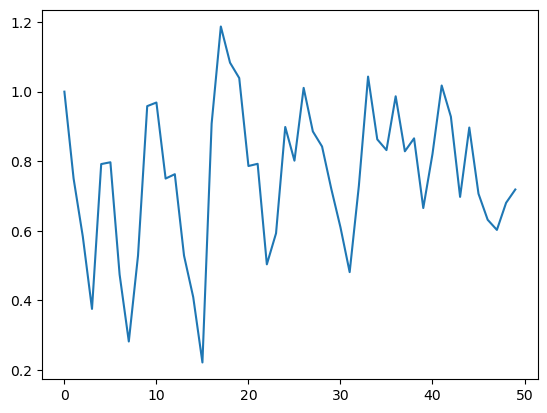

In [29]:
res['Avg. MinMax Vote Diff'].plot()

---

# To Do:
### 1. Write the function that loops through all n, and returns the optimal vote credit total for each.
### 2. Redo this with negative voting.
### 3. Explore continuous voting.

##### Discovery: The minimal number of credits which allow for strategies where no two numbers are equal (min diff > 0) is equal to the [n-1, n-2,...,0] strategy credit level.